# Redes reales

Importemos las librerías que podríamos usar:

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#  ¿qué datos son? ¿cómo están relacionados los nodos? ¿cuántos son? ¿cuántas aristas tienen? 

In [19]:
from pathlib import Path
import networkx as nx

D = Path("data\dataverse\gexf")  # change this

graphs = {}  # {int_id: nx.Graph}

for fp in D.iterdir():
    if fp.suffix.lower() != ".gexf":      # skips .DS_Store and anything else
        continue
    try:
        movie_id = int(fp.stem)           # expects "1.gexf", "914.gexf", etc.
    except ValueError:
        continue                          # skip weird names if any

    # node_type=int makes node IDs usable as ints (optional; remove if you want strings)
    G = nx.read_gexf(fp, node_type=int)
    graphs[movie_id] = G

print("loaded:", len(graphs), "graphs")
print("example:", min(graphs), graphs[min(graphs)].number_of_nodes(), graphs[min(graphs)].number_of_edges())


<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\herie\AppData\Local\Temp\ipykernel_25984\1577325245.py:4: SyntaxWarning: invalid escape sequence '\d'
  D = Path("data\dataverse\gexf")  # change this


loaded: 773 graphs
example: 1 21 68


In [21]:
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


def load_movie_metadata(metadata_tab_path: str) -> pd.DataFrame:
    """
    Returns a DataFrame indexed by GexfID with columns like Title, ReleaseDate, IMDB_id, etc.
    """
    md = pd.read_csv(metadata_tab_path, sep="\t")
    return md.set_index("GexfID")


def read_movie_gexf(folder: str, movie_id: int, *, node_type=int) -> nx.Graph:
    """
    Reads <movie_id>.gexf from folder into a NetworkX graph.
    """
    fp = Path(folder) / f"{movie_id}.gexf"
    return nx.read_gexf(fp, node_type=node_type)


def _gephi_pos_if_present(G: nx.Graph):
    """
    Moviegalaxies GEXFs often store Gephi positions under node['viz']['position'].
    If present, use them; otherwise return None.
    """
    pos = {}
    for n, d in G.nodes(data=True):
        p = d.get("viz", {}).get("position")
        if p is not None:
            pos[n] = (float(p["x"]), float(p["y"]))
    return pos if len(pos) == G.number_of_nodes() else (pos if pos else None)


def draw_movie_graph(
    folder: str,
    movie_id: int,
    metadata_tab_path: str,
    *,
    label_top_k: int | None = None,
    use_gephi_layout: bool = True,
    figsize=(10, 8),
):
    """
    Draws the character network for one movie:
    - plot title: movie Title (and year if available)
    - node labels: character names (node attribute 'label')
    - sizes/colors: taken from Gephi 'viz' if available, else fallback to degree/defaults
    - edges: width scaled by 'weight' if present
    """
    md = load_movie_metadata(metadata_tab_path)
    row = md.loc[movie_id] if movie_id in md.index else None

    title = f"{row['Title']}" if row is not None and "Title" in row else f"Movie {movie_id}"
    year = f" ({int(row['ReleaseDate'])})" if row is not None and pd.notna(row.get("ReleaseDate")) else ""
    subtitle = f"GexfID={movie_id} | n={None} | m={None}"

    G = read_movie_gexf(folder, movie_id, node_type=int)
    subtitle = f"GexfID={movie_id} | n={G.number_of_nodes()} | m={G.number_of_edges()}"

    # layout
    pos = _gephi_pos_if_present(G) if use_gephi_layout else None
    if not pos:
        pos = nx.spring_layout(G, seed=0)

    # node aesthetics
    degrees = dict(G.degree())
    node_sizes = []
    node_colors = []
    for n, d in G.nodes(data=True):
        viz = d.get("viz", {})
        # size
        if "size" in viz:
            node_sizes.append(float(viz["size"]) * 80.0)  # scale for matplotlib
        else:
            node_sizes.append(50.0 + 25.0 * degrees.get(n, 0))
        # color
        c = viz.get("color")
        if c:
            node_colors.append((c["r"]/255.0, c["g"]/255.0, c["b"]/255.0))
        else:
            node_colors.append((0.5, 0.5, 0.5))  # neutral fallback

    # edge aesthetics (weight -> width)
    weights = []
    for _, _, ed in G.edges(data=True):
        w = ed.get("weight", 1.0)
        try:
            w = float(w)
        except Exception:
            w = 1.0
        weights.append(w)
    wmax = max(weights) if weights else 1.0
    edge_widths = [0.5 + 2.5 * (w / wmax) for w in weights]  # in [0.5, 3.0]

    # labels: by default label all if small, else label top-k by degree
    n_nodes = G.number_of_nodes()
    if label_top_k is None:
        label_top_k = n_nodes if n_nodes <= 40 else 30
    top_nodes = sorted(G.nodes(), key=lambda x: degrees.get(x, 0), reverse=True)[:label_top_k]
    labels = {n: G.nodes[n].get("label", str(n)) for n in top_nodes}

    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.30, width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, linewidths=0.5, edgecolors="black")
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title(f"{title}{year}\n{subtitle}", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return G  # convenient if you want to keep working with it


# ---- usage ----
# folder = "/path/to/your/gexf_folder"
# metadata = "/mnt/data/network_metadata.tab"  # or your local path
# G1 = draw_movie_graph(folder, 1, metadata, label_top_k=50)


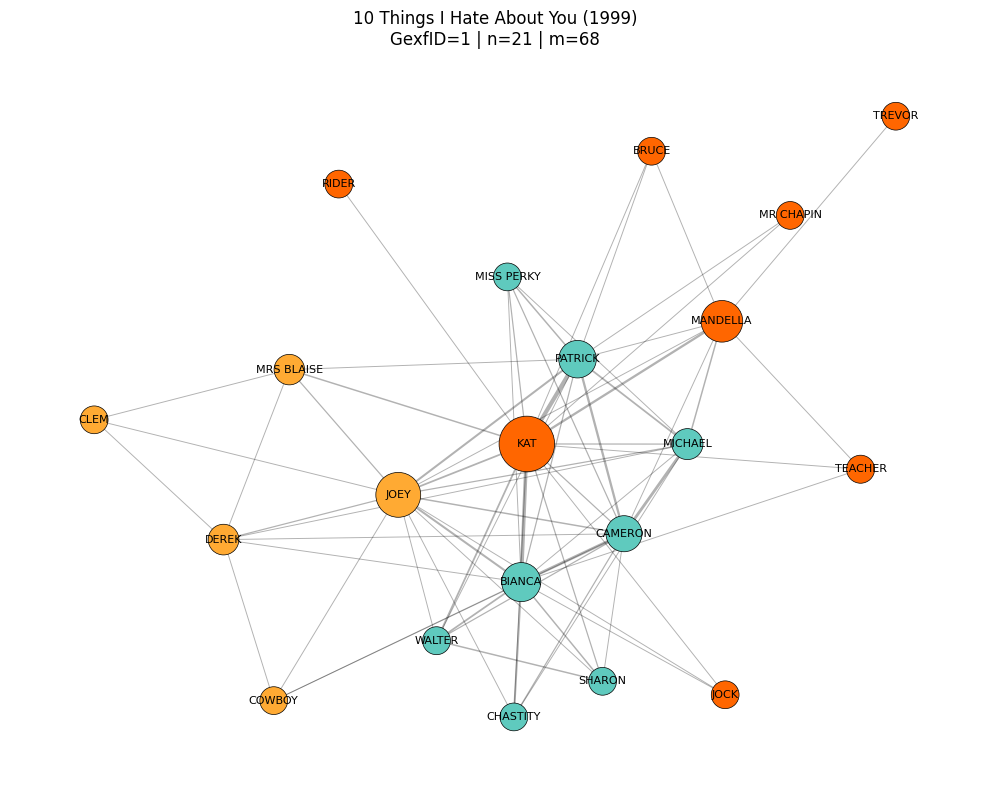

In [39]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 1, metadata, label_top_k=50)

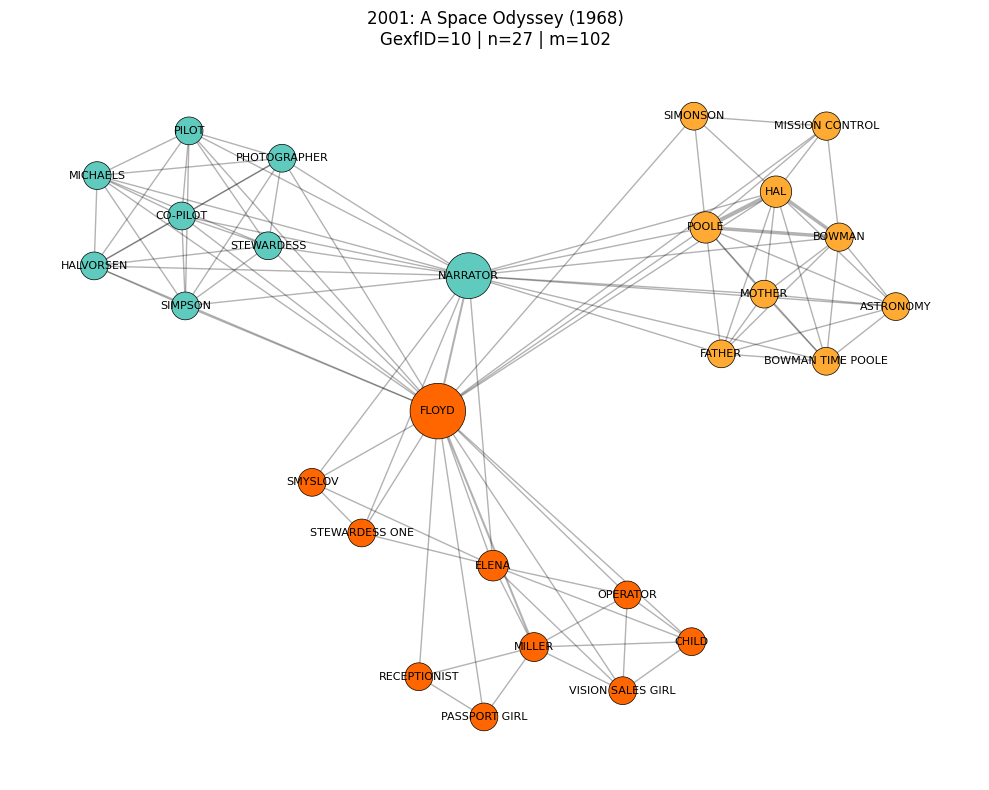

In [38]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 10, metadata, label_top_k=50)

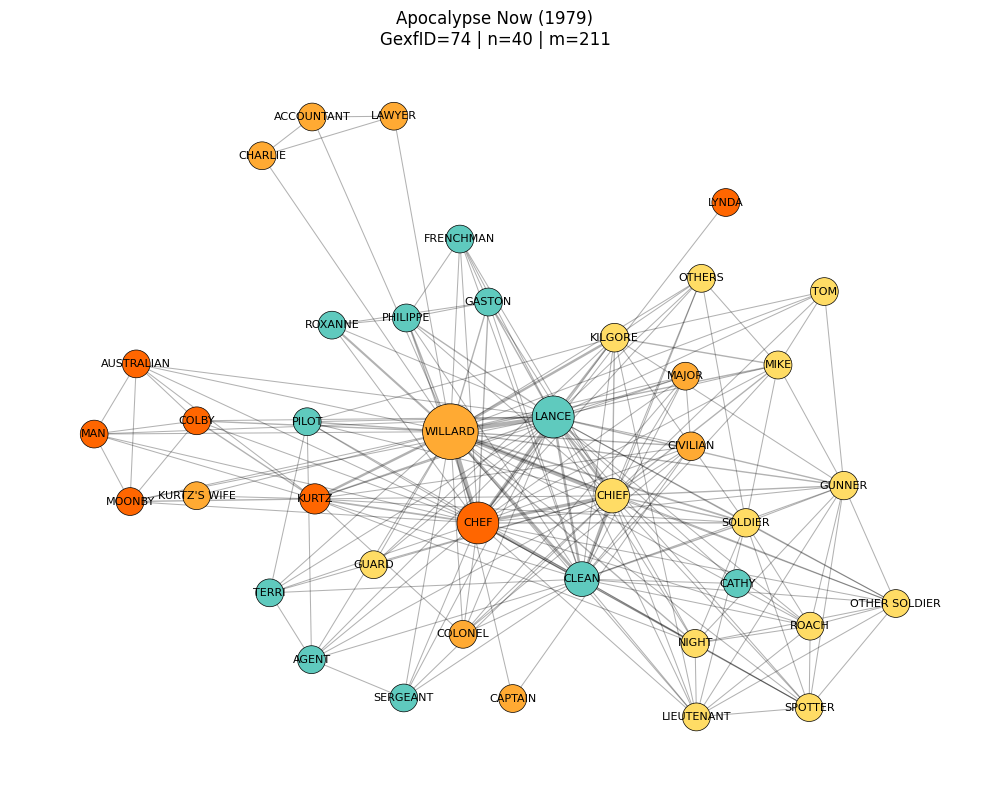

In [37]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 74, metadata, label_top_k=50)

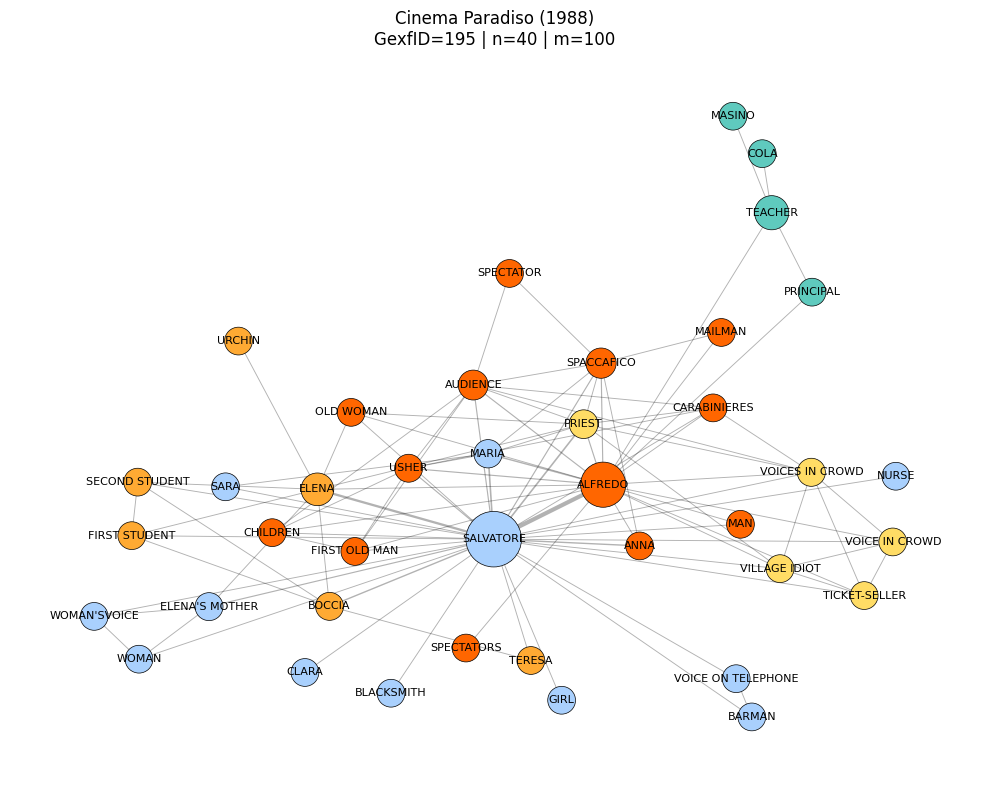

In [40]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 195, metadata, label_top_k=50)

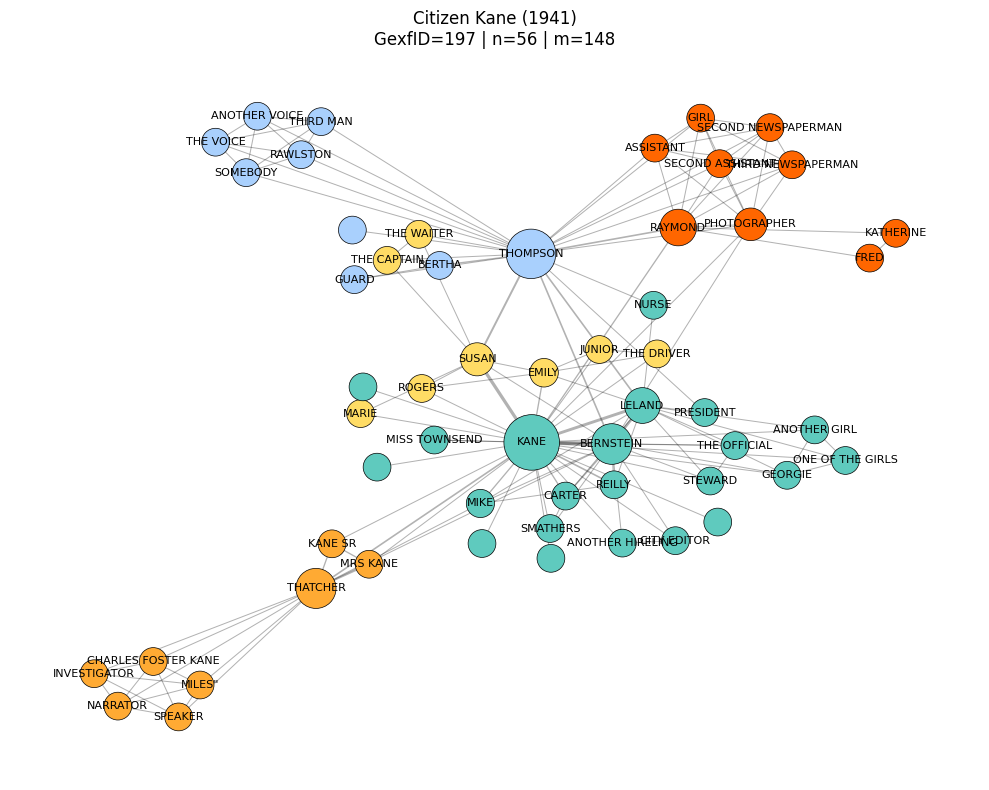

In [41]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 197, metadata, label_top_k=50)

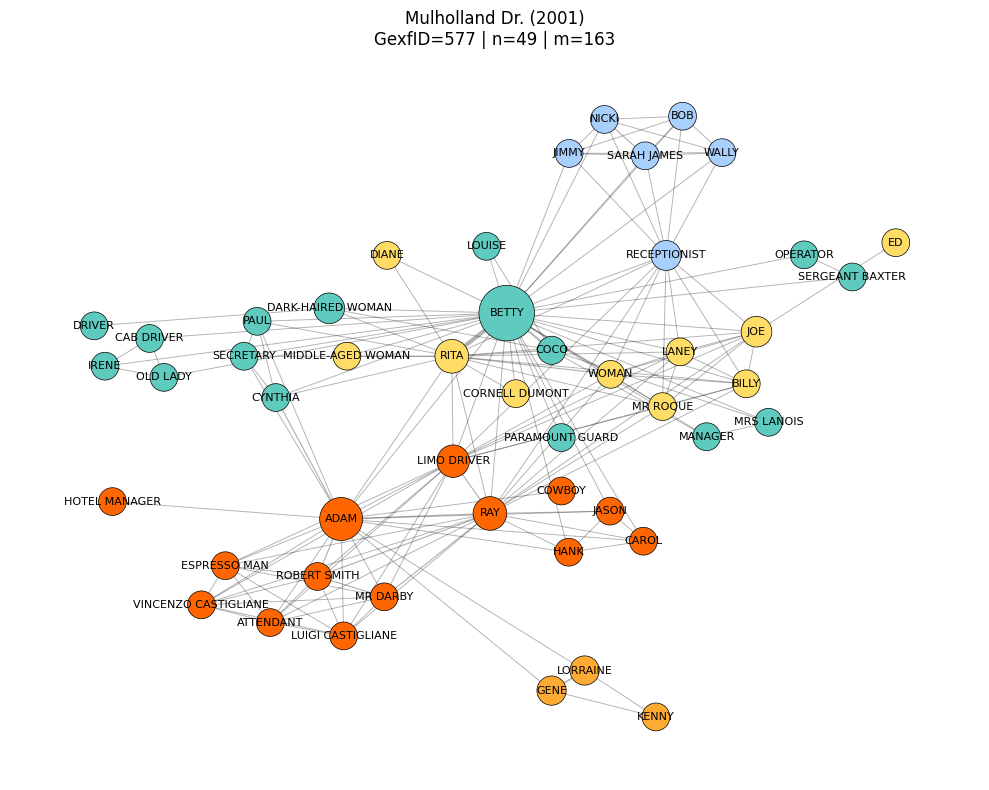

In [63]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 577, metadata, label_top_k=50)

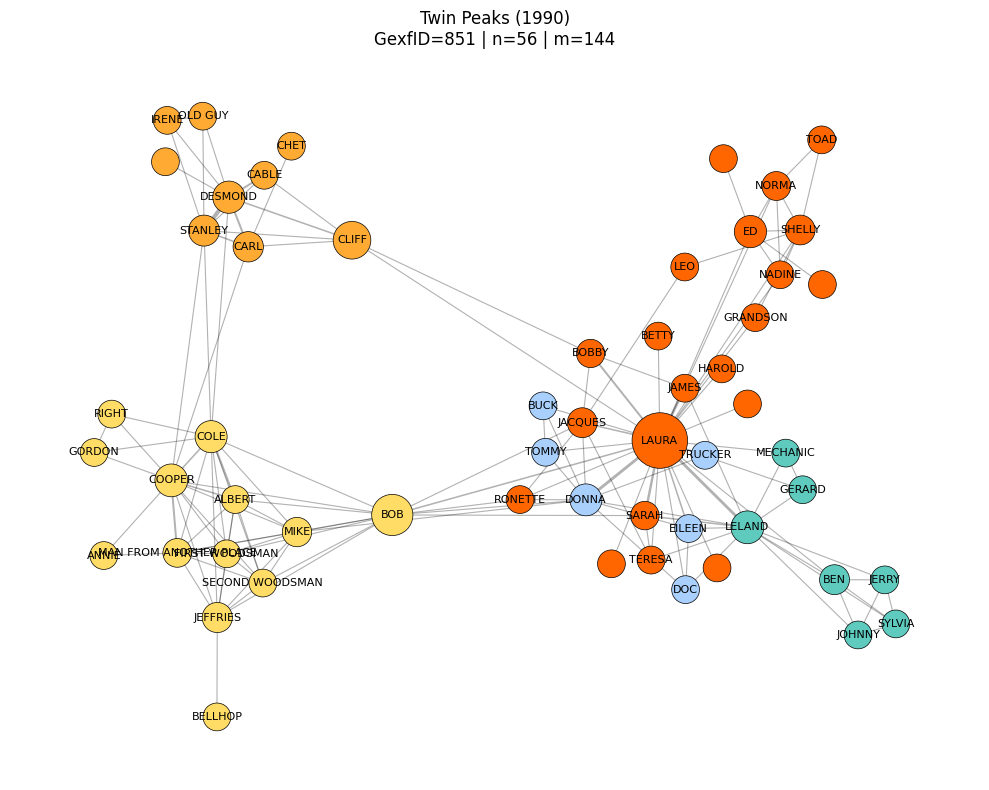

In [64]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 851, metadata, label_top_k=50)

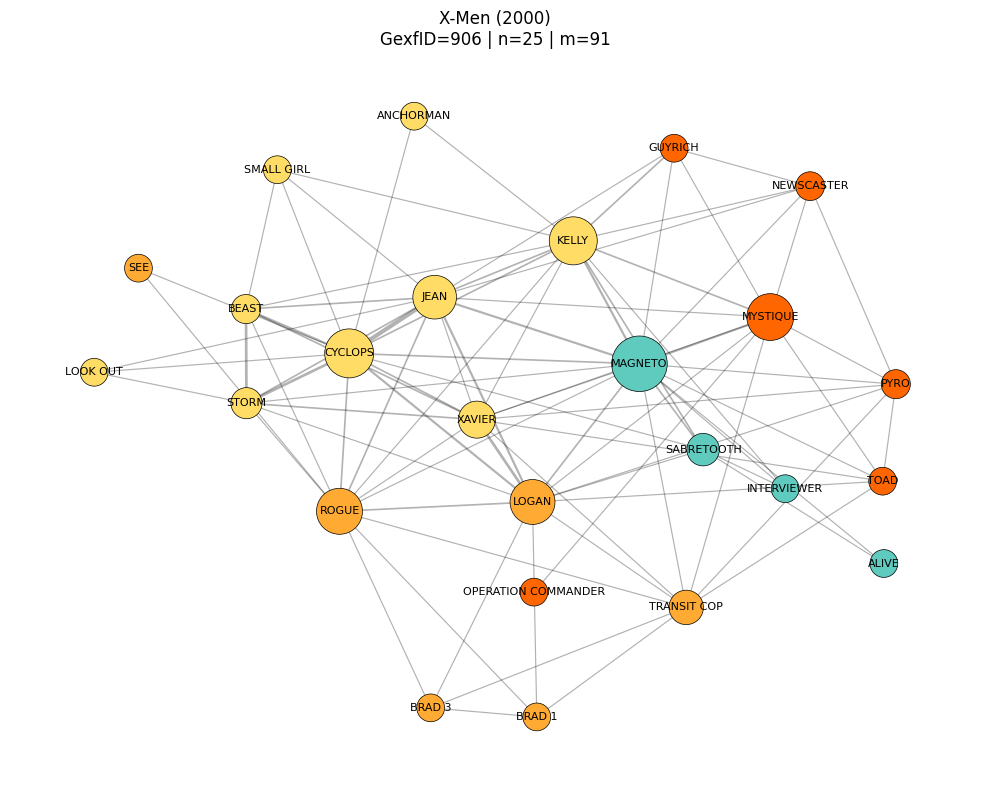

In [65]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 906, metadata, label_top_k=50)

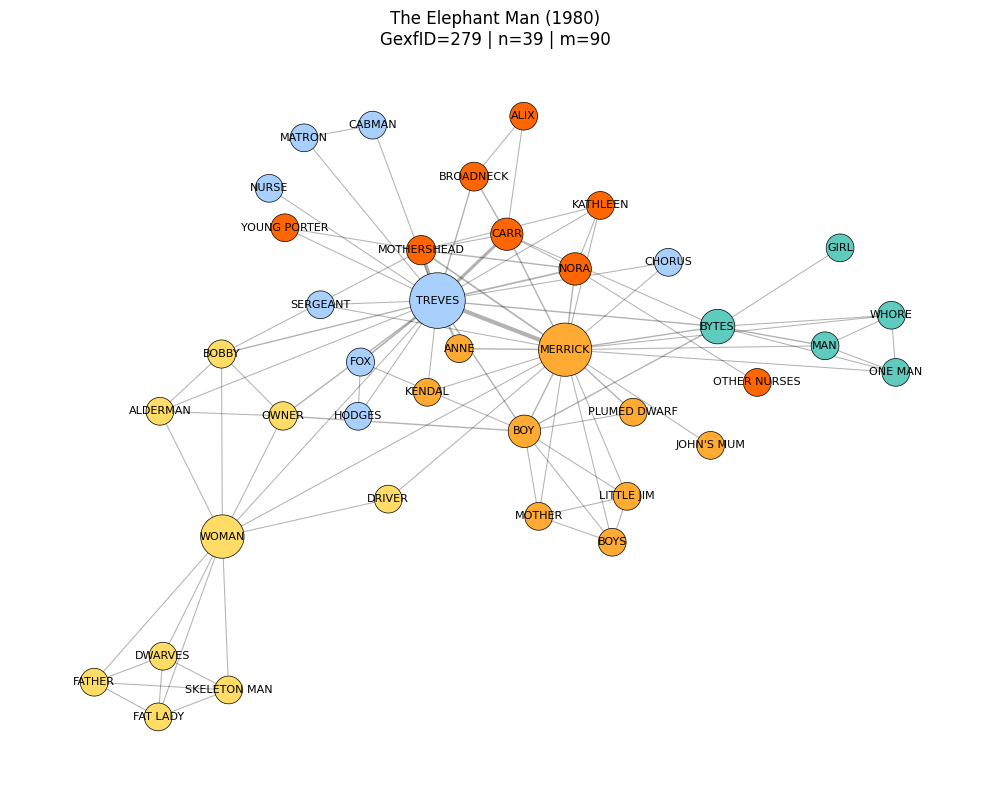

In [62]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 279, metadata, label_top_k=50)

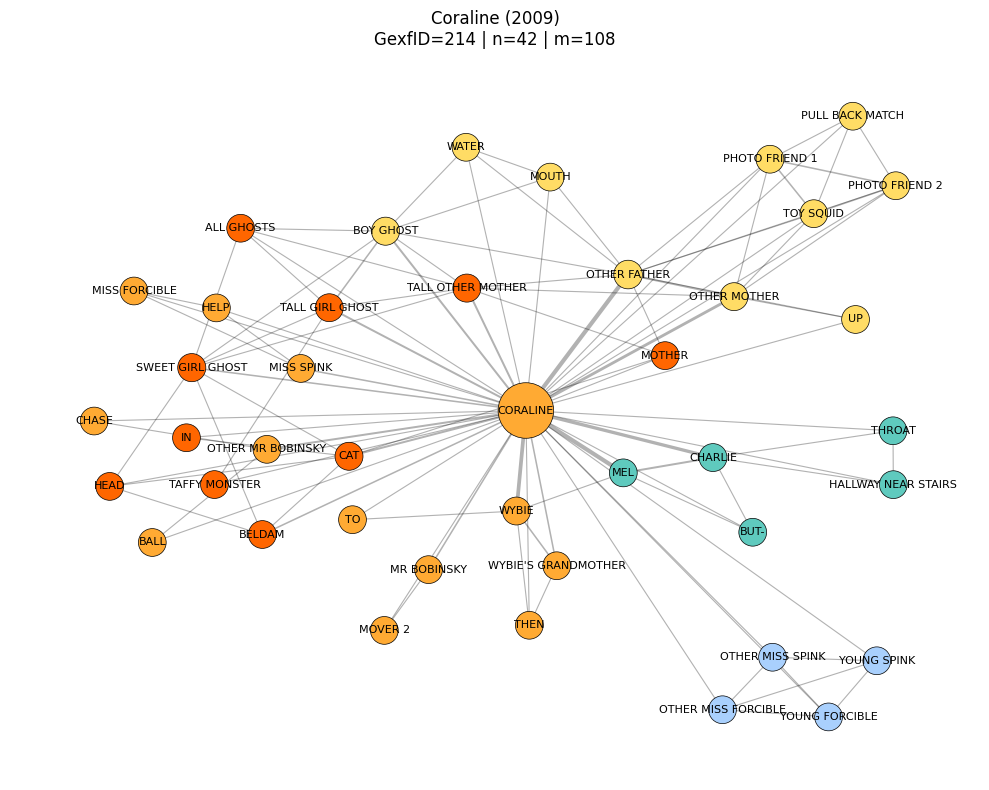

In [42]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 214, metadata, label_top_k=50)

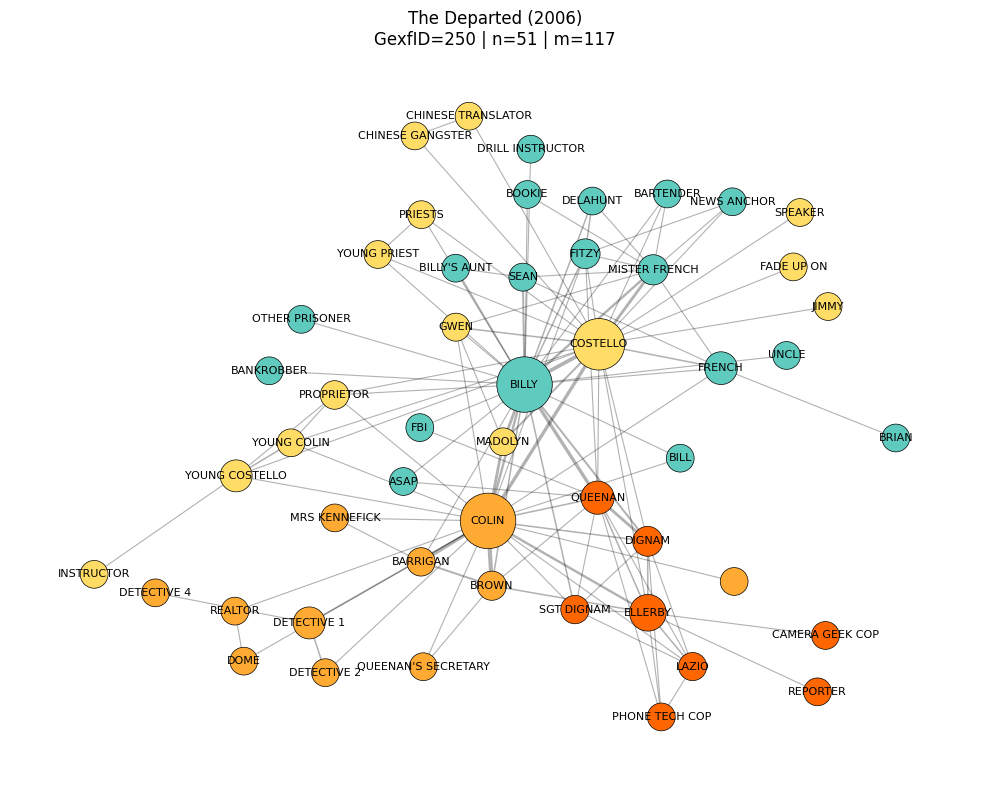

In [44]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 250, metadata, label_top_k=50)

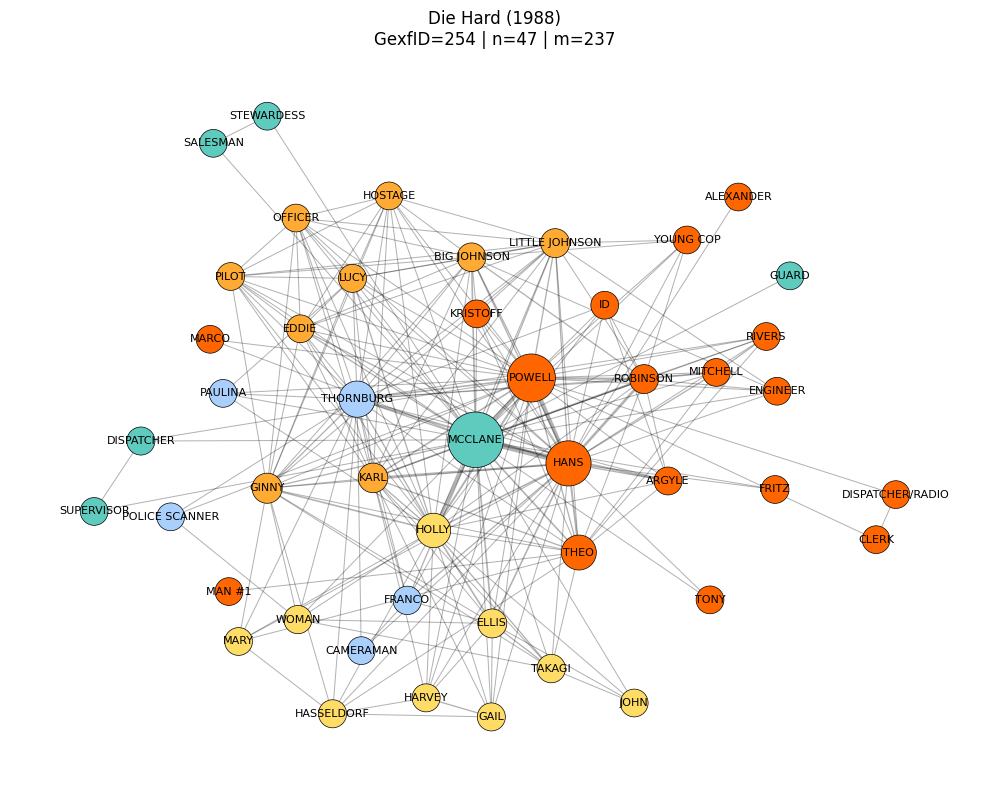

In [45]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 254, metadata, label_top_k=50)

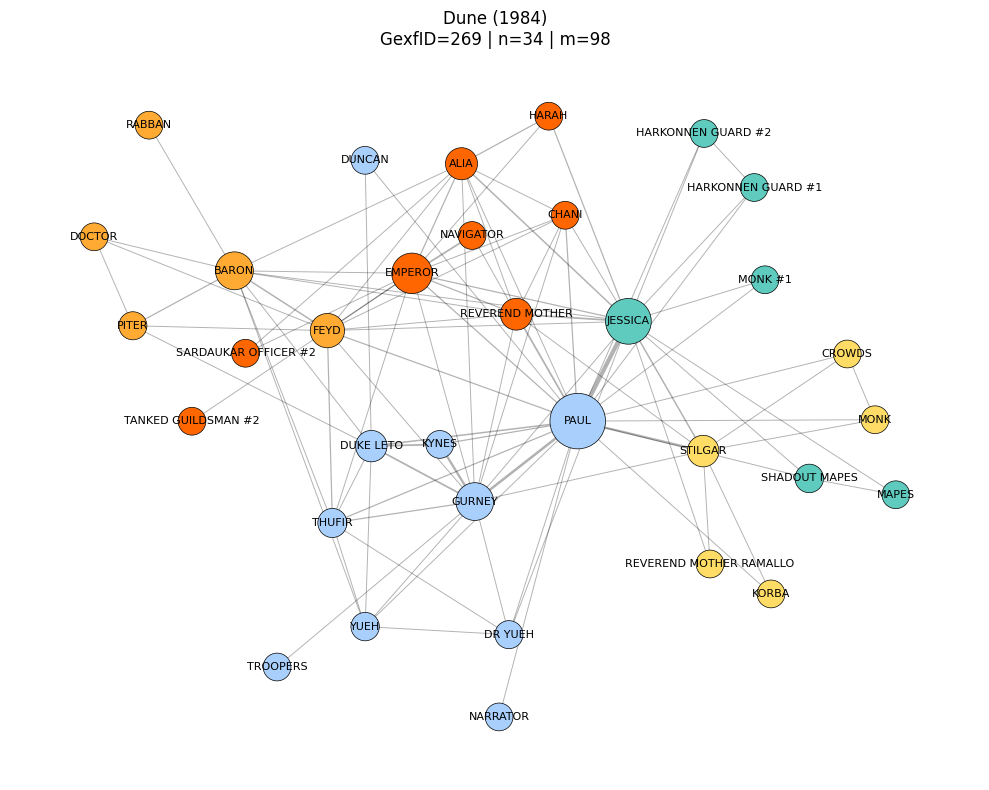

In [46]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 269, metadata, label_top_k=50)

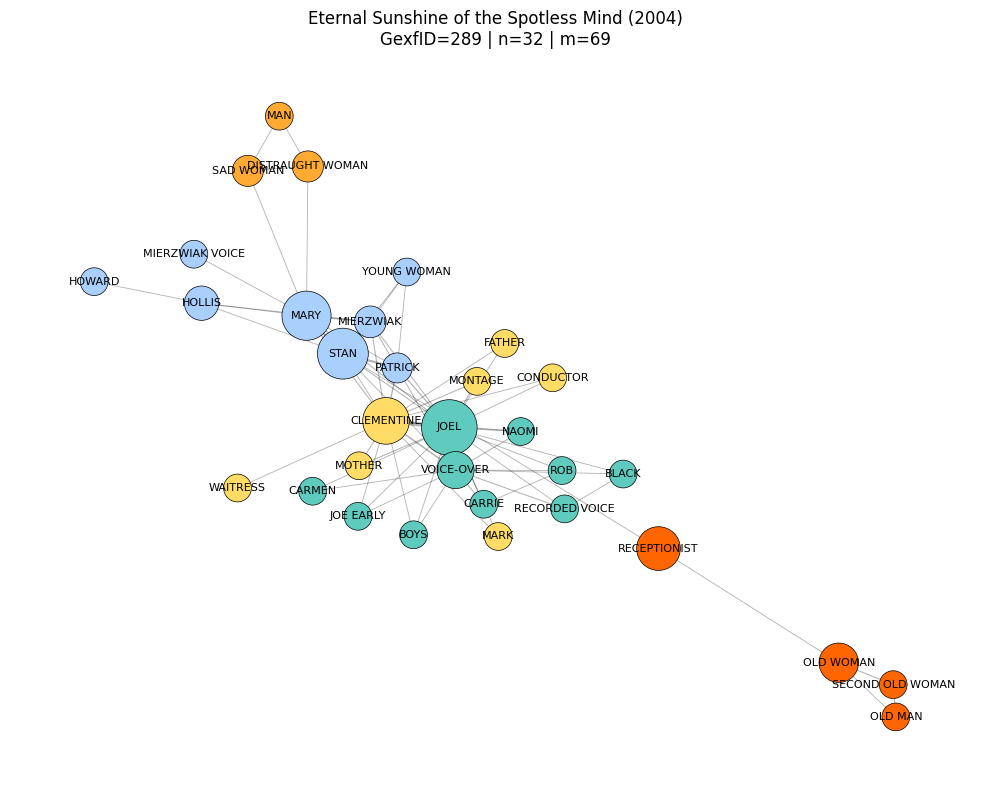

In [47]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 289, metadata, label_top_k=50)

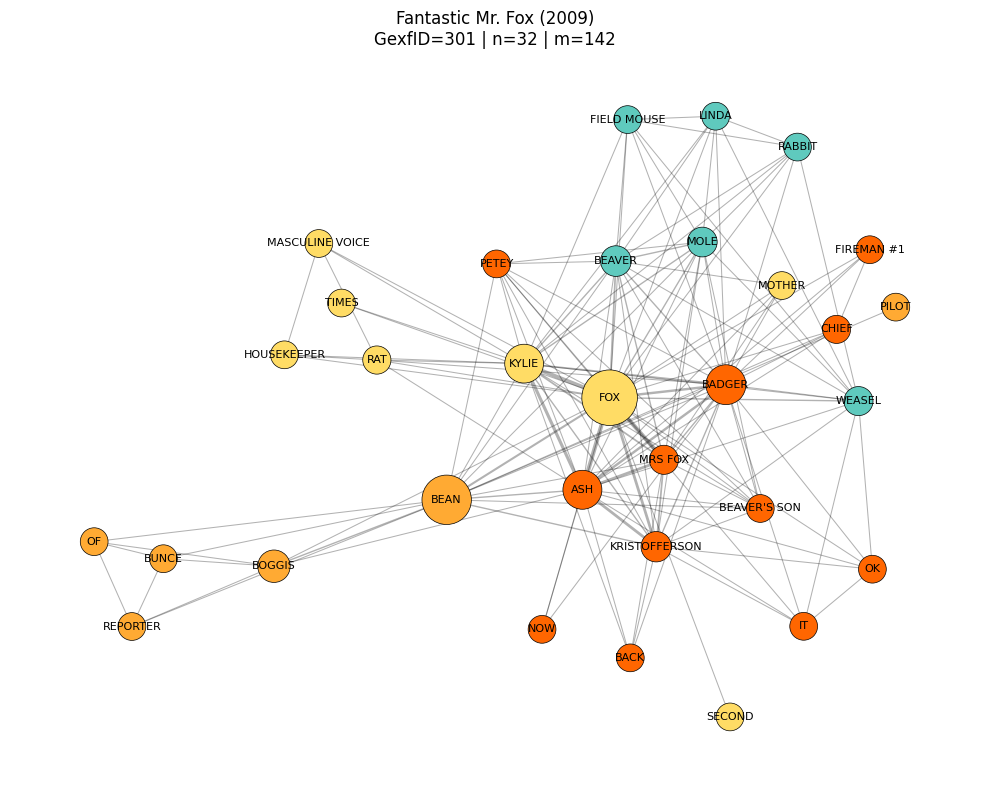

In [48]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 301, metadata, label_top_k=50)

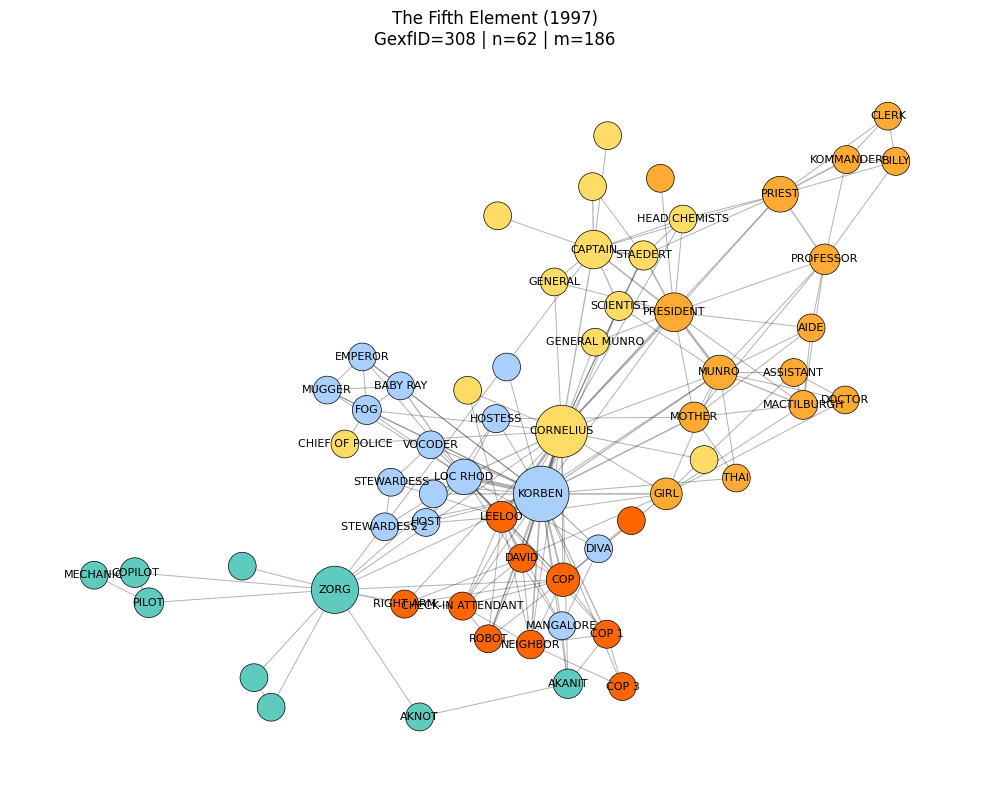

In [49]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 308, metadata, label_top_k=50)

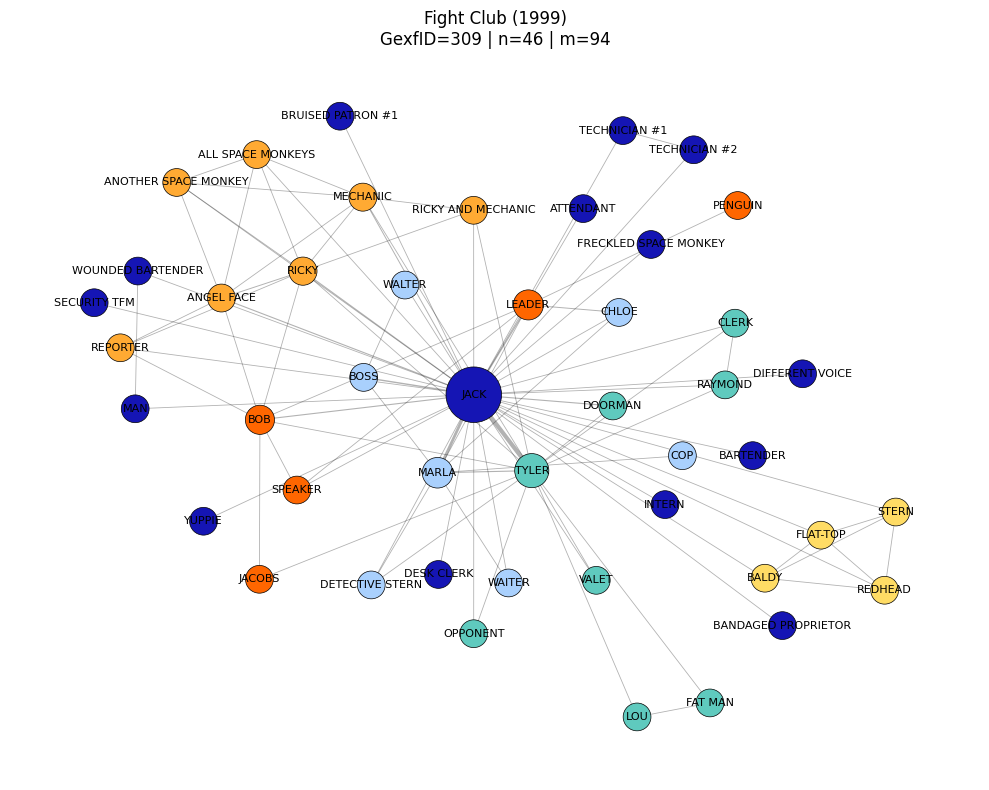

In [50]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 309, metadata, label_top_k=50)

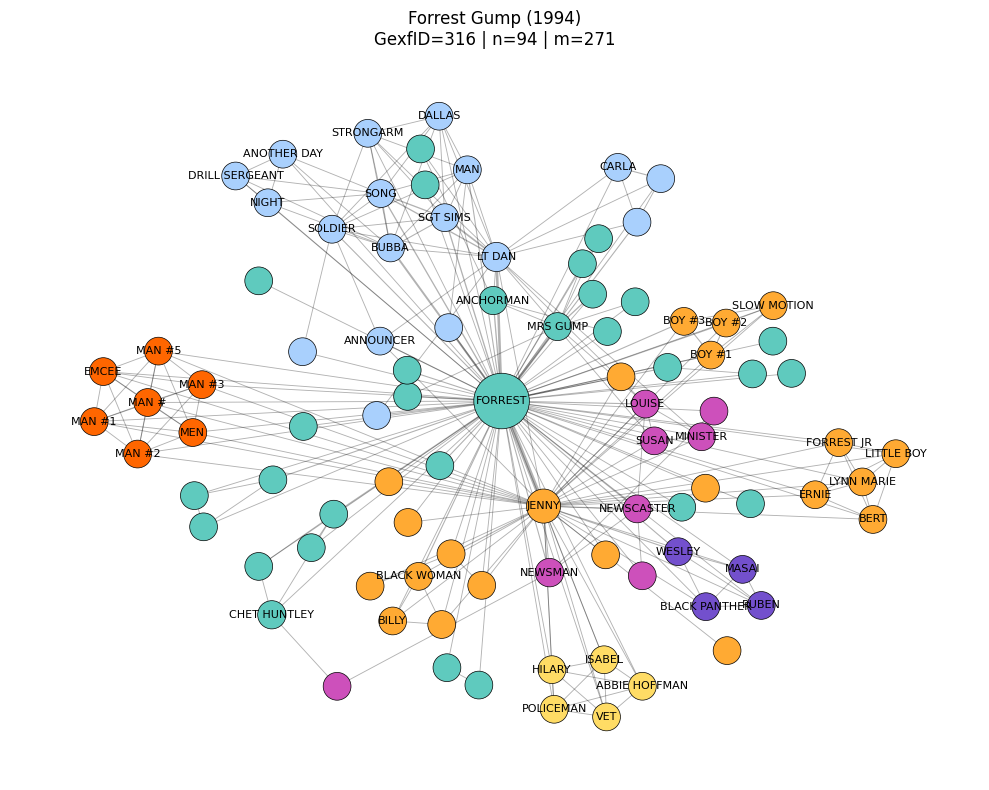

In [51]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 316, metadata, label_top_k=50)

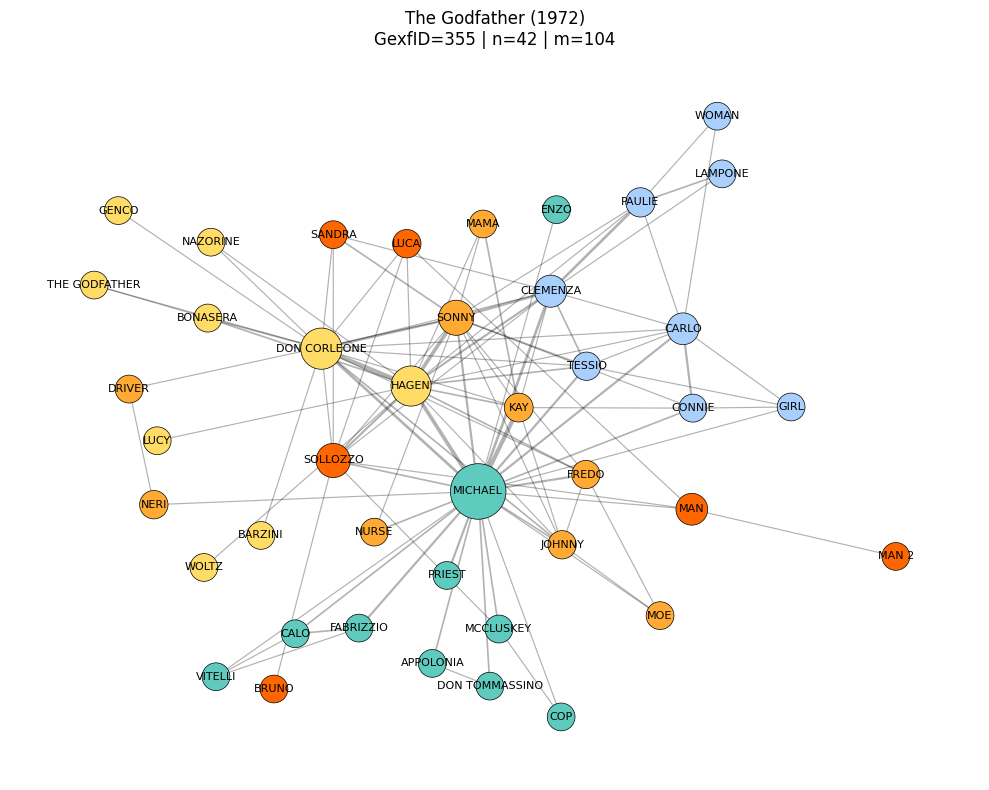

In [52]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 355, metadata, label_top_k=50)

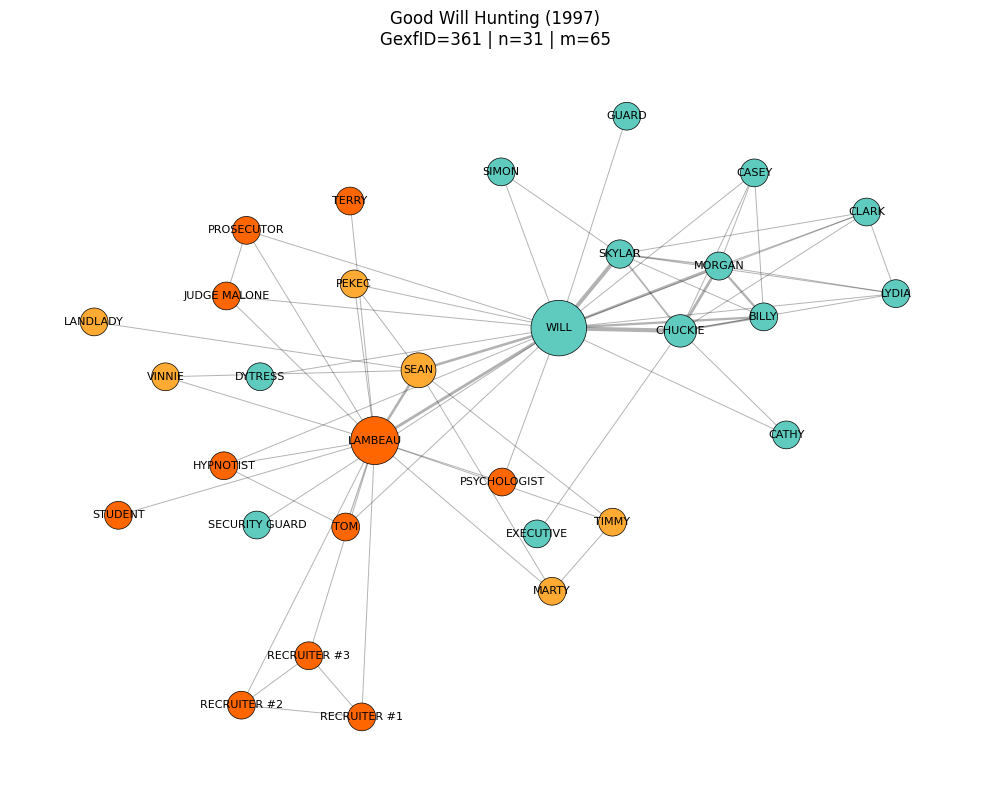

In [53]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 361, metadata, label_top_k=50)

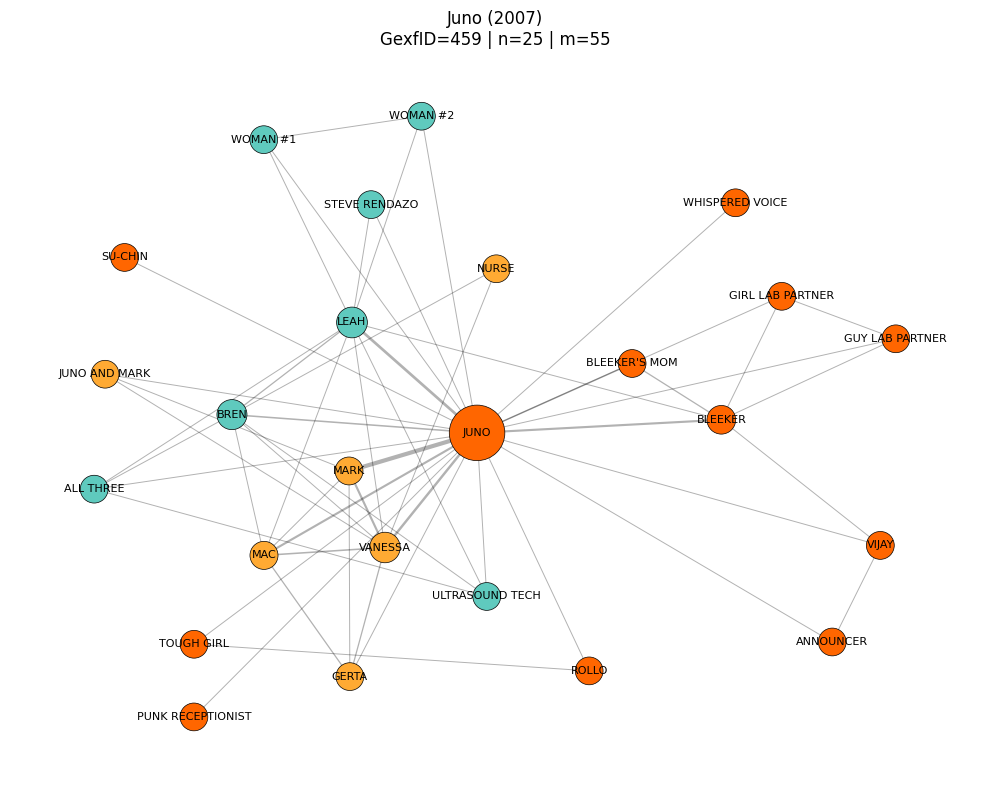

In [54]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 459, metadata, label_top_k=50)

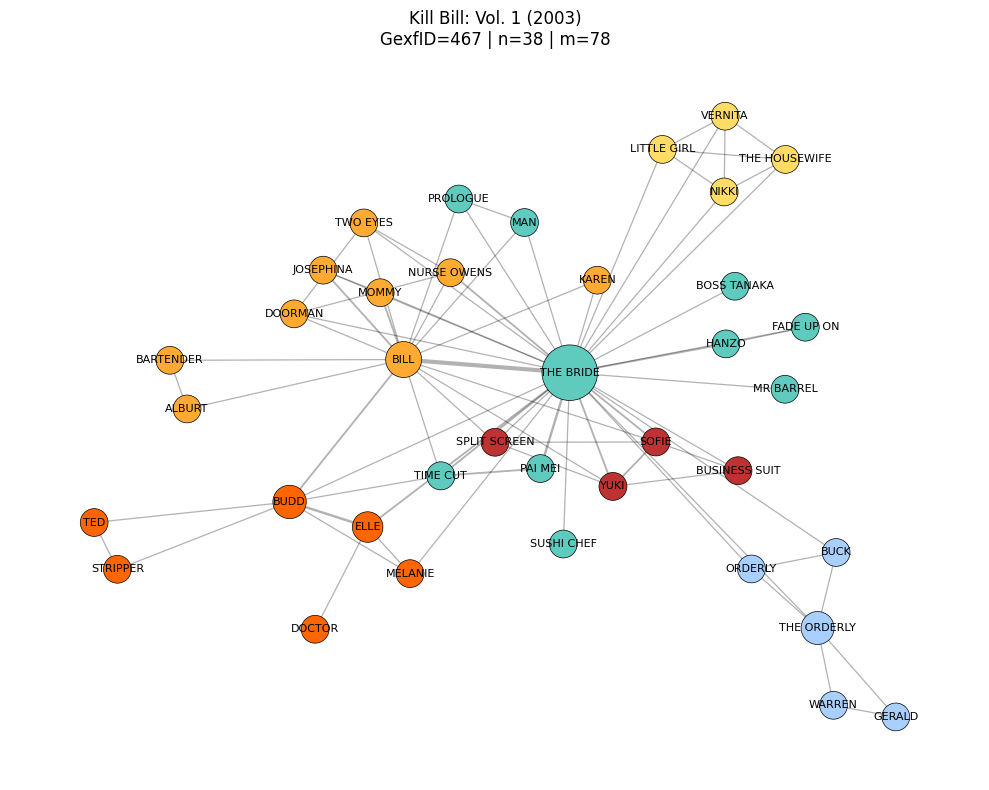

In [55]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 467, metadata, label_top_k=50)

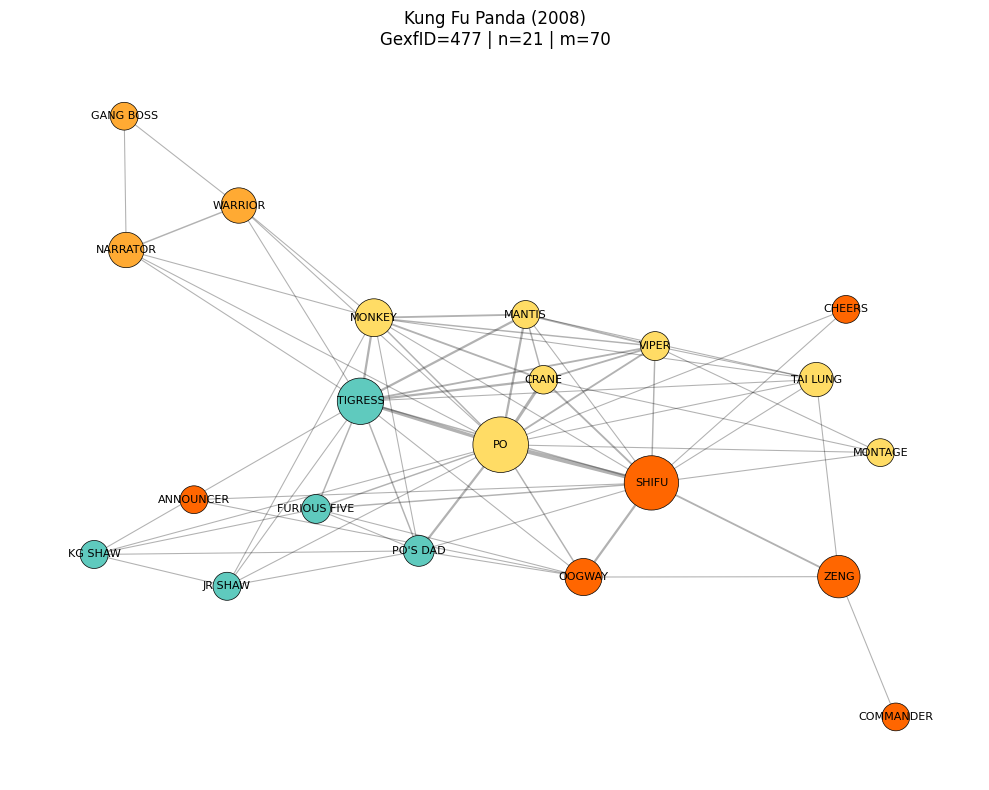

In [56]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 477, metadata, label_top_k=50)

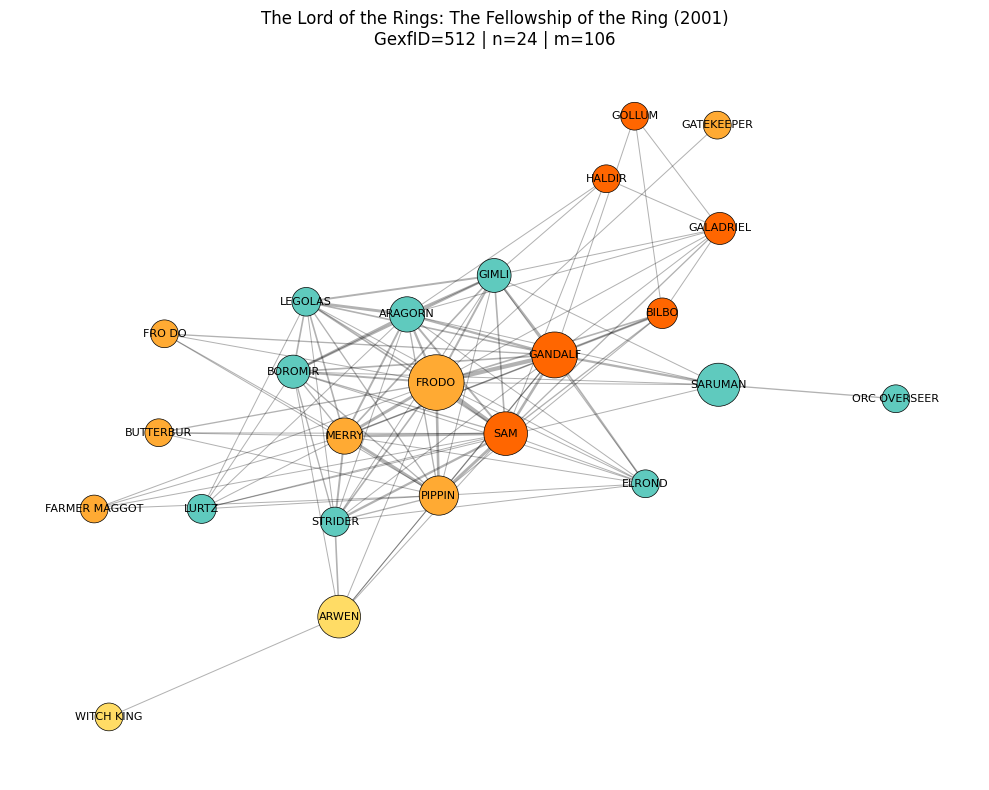

In [57]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 512, metadata, label_top_k=50)

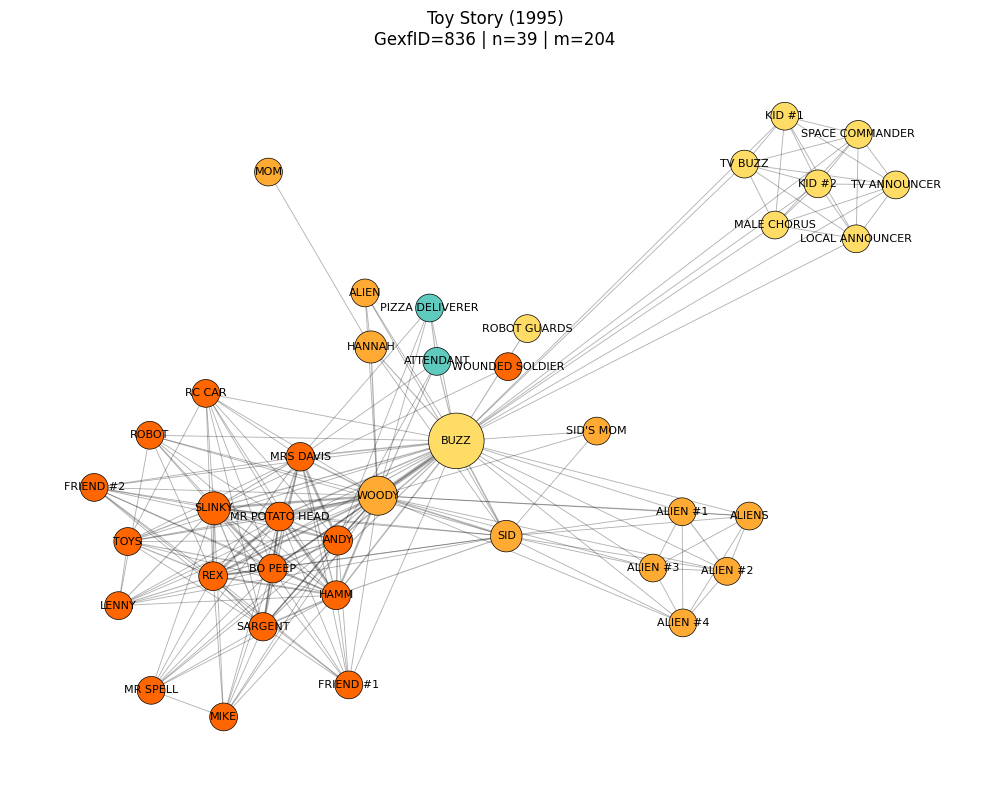

In [58]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 836, metadata, label_top_k=50)

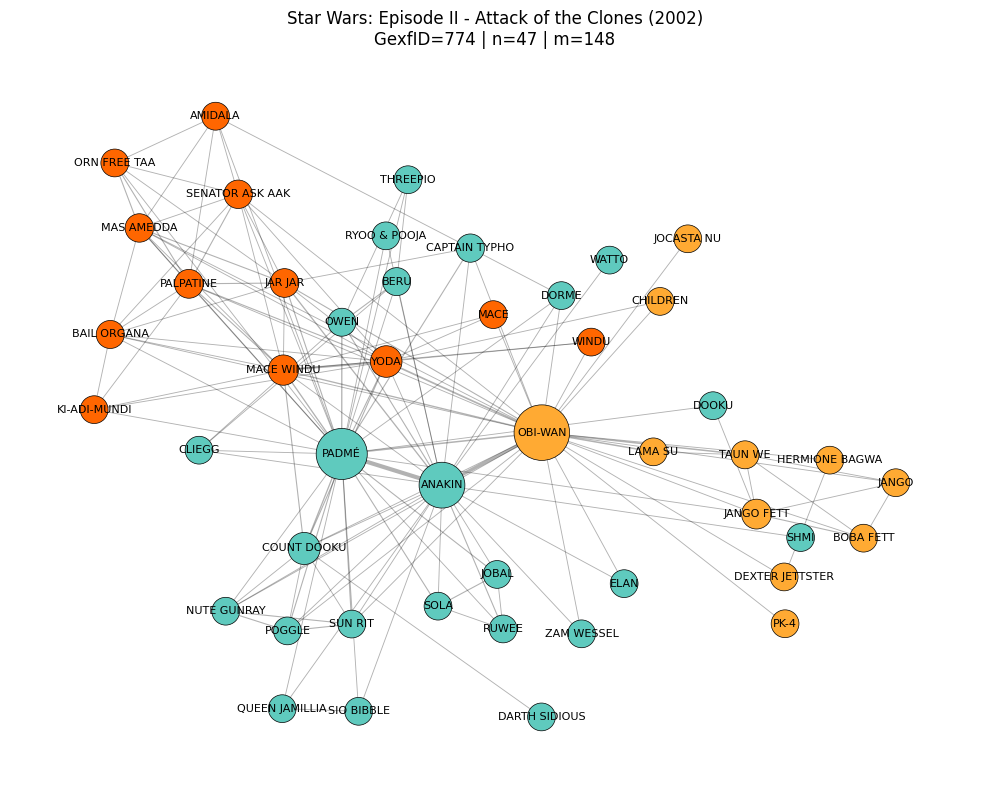

In [60]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 774, metadata, label_top_k=50)

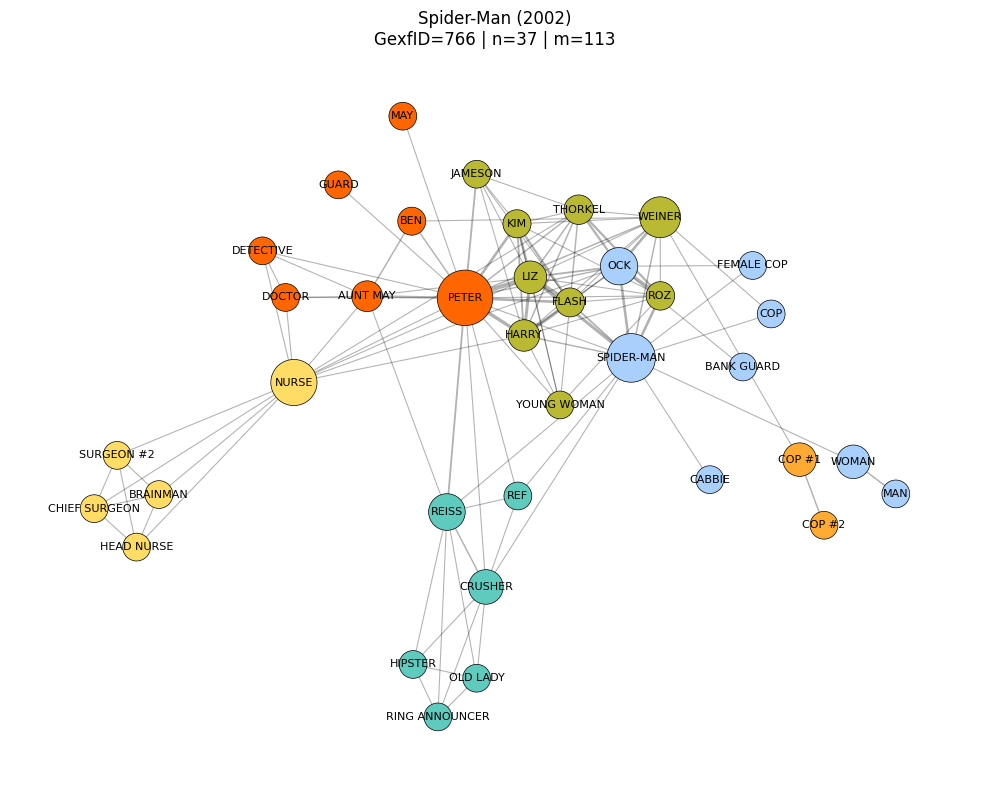

In [61]:
folder = "data/dataverse/gexf"
metadata = "data/dataverse/network_metadata.tab"
G1 = draw_movie_graph(folder, 766, metadata, label_top_k=50)

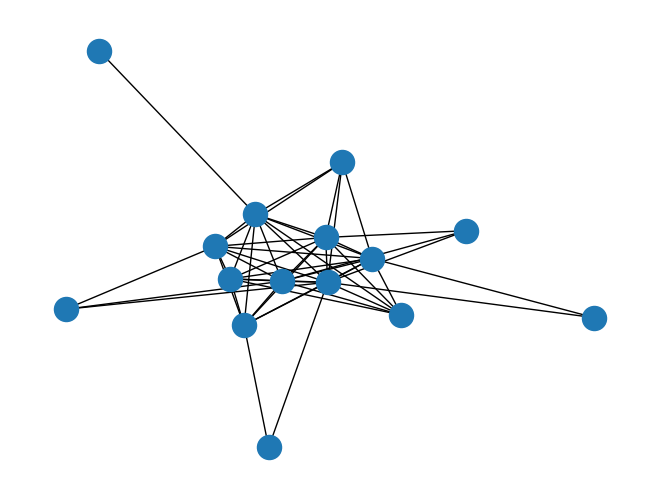

In [20]:
nx.draw(G)

# Realiza tres visualizaciones distintas cambiando opciones como diseño (layout), forma, tamaño o color de nodos, color de aristas, etc.

# Genera la matriz de adyacencia de la red.

# Utiliza la función "subgraph" para extraer una subred de 8 nodos y visualizarla.

# Realiza una lista de grados: Identifica los nodos con mayor y con menor grado

# Encuentra el grado promedio

# Encuentra la densidad: ¿consideras que la red es dispersa o densa?

# Encuentra la cantidad de componentes

# Calcula la distancia entre algunos nodos, por ejemplo, entre los de mayor y menor grado.

# Calcula el diámetro, en caso de que la red sea disconexa, calcular el diámetro de cada componente

# Calcula la conectividad por aristas y por nodos entre algunos pares de nodos (por ejemplo entre los de mayor y menor grado)

# Encuentra un conjunto mínimo de nodos de corte.

# Calcula su matriz Laplaciana (omite direcciones si es necesario), sus eigenvalores y sus eigenvectores (el espectro). Verifica que la multiplicidad del eigenvalor cero es la misma que la cantidad de componentes 